## Tutorial on chemical reaction network (CRN) inference

Dependecies: `Catalyst, OrdinaryDiffEq, StableRNGs, CairoMakie, Colors, Optim, LineSearches`

In [1]:
VERSION

v"1.11.3"

### Simulating a CRN

Fisrt, we simulate a synthetic dataset based on the following CRN, i.e. our ground-truth CRN:
$$ X_1\xrightarrow[]{k_{1}}X_2, \qquad X_1+X_2\xrightleftharpoons[k_{13}]{k_{18}}X_3.$$
The subscripts of the reaction rate constants will be explained later when we introduce the library CRN.

The `@reaction_network` macro from `Catalyst.jl` enables us to programatically define CRNs. Note that package imports and first calls to functions take longer times to run due to compilation.

In [2]:
using Catalyst

true_crn = @reaction_network begin
	k₁, X₁ --> X₂                  # irreversible reaction
	(k₁₈, k₁₃), X₁ + X₂ <--> X₃	   # reversible reaction
end

Model ##ReactionSystem#236:
Unknowns (3): see unknowns(##ReactionSystem#236)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (3): see parameters(##ReactionSystem#236)
  k₁
  k₁₈
  k₁₃

`Catalyst.jl` features functionality to automatically derive the corresponding ordinary differential equation (ODE) system (assuming mass-action kinetics).

In [3]:
convert(ODESystem, true_crn)

Model ##ReactionSystem#236:
Equations (3):
  3 standard: see equations(##ReactionSystem#236)
Unknowns (3): see unknowns(##ReactionSystem#236)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (3): see parameters(##ReactionSystem#236)
  k₁
  k₁₈
  k₁₃

$X_i(t)$ denotes the concentration of species $X_i$ at time $t$. To simulate the dynamics of this ODE system, say over $t\in[0,10]$, we need to define and solve an `ODEProblem`. We will use the initial values $(X_1(0), X_2(0), X_3(0)) = (0,0,1)$ and set the reaction rate constants as $(k_{1},k_{13},k_{18})=(1,1,1)$.

In [4]:
using OrdinaryDiffEq

t_span = (0., 10.) # time interval to solve on
x0map = [:X₁ => 0., :X₂ => 0., :X₃ => 1.] # initial conditions
true_kmap  = (:k₁ => 1., :k₁₈ => 1., :k₁₃ => 1.) # ground-truth reaction rate constants

true_oprob = ODEProblem(true_crn, x0map, t_span, true_kmap)
true_sol = solve(true_oprob);

Next, we extract the ODE solution at $101$ equally-spaced time points `t_obs`. Note that `true_sol(t_obs).u` is a vector of vectors (one vector per time point). We concatenate these vectors into a matrix (one column per time point).

In [5]:
n_obs = 101
t_obs = range(t_span..., n_obs)
data_noiseless = reduce(hcat, true_sol(t_obs).u)
# reduce(hcat, vectors) concatenates all vectors together as columns 

3×101 Matrix{Float64}:
 0.0  0.0901911  0.16171   0.216322  …  0.0135083  0.0131308  0.0127647
 0.0  0.0995337  0.196541  0.28922      1.91539    1.91768    1.9199
 1.0  0.905138   0.820874  0.747229     0.0355485  0.0345941  0.0336656

To simulate noisy data, we introduce additive normal noise (independently and identically distributed) with standard deviation $\sigma=0.01$, and clamp the values to be nonnegative.

In [6]:
using Random, StableRNGs
rng = StableRNG(1) # random number generator for reproducibility

σ = 0.01
data = data_noiseless .+ σ .* randn(rng, size(data_noiseless)) # additive normal noise
data = max.(data, 0); # clamp negative values to 0

We plot the noisy data along with the groud-truth trajectories.

In [7]:
# Plotting setup
using CairoMakie
using Colors
set_theme!(theme_latexfonts());
update_theme!(
	Axis=(;
		xgridvisible=false, ygridvisible=false,
		xlabelsize=16, ylabelsize=16,
		titlesize=16,
	),
)
palette = Makie.wong_colors(); # Makie's default colour scheme
# helper function to lighten a color c (w=1 returns original colour, w=0 returns white)
lighten(c, w) = RGB((1 .- (1 .- [c.r, c.g, c.b]).*w)...);

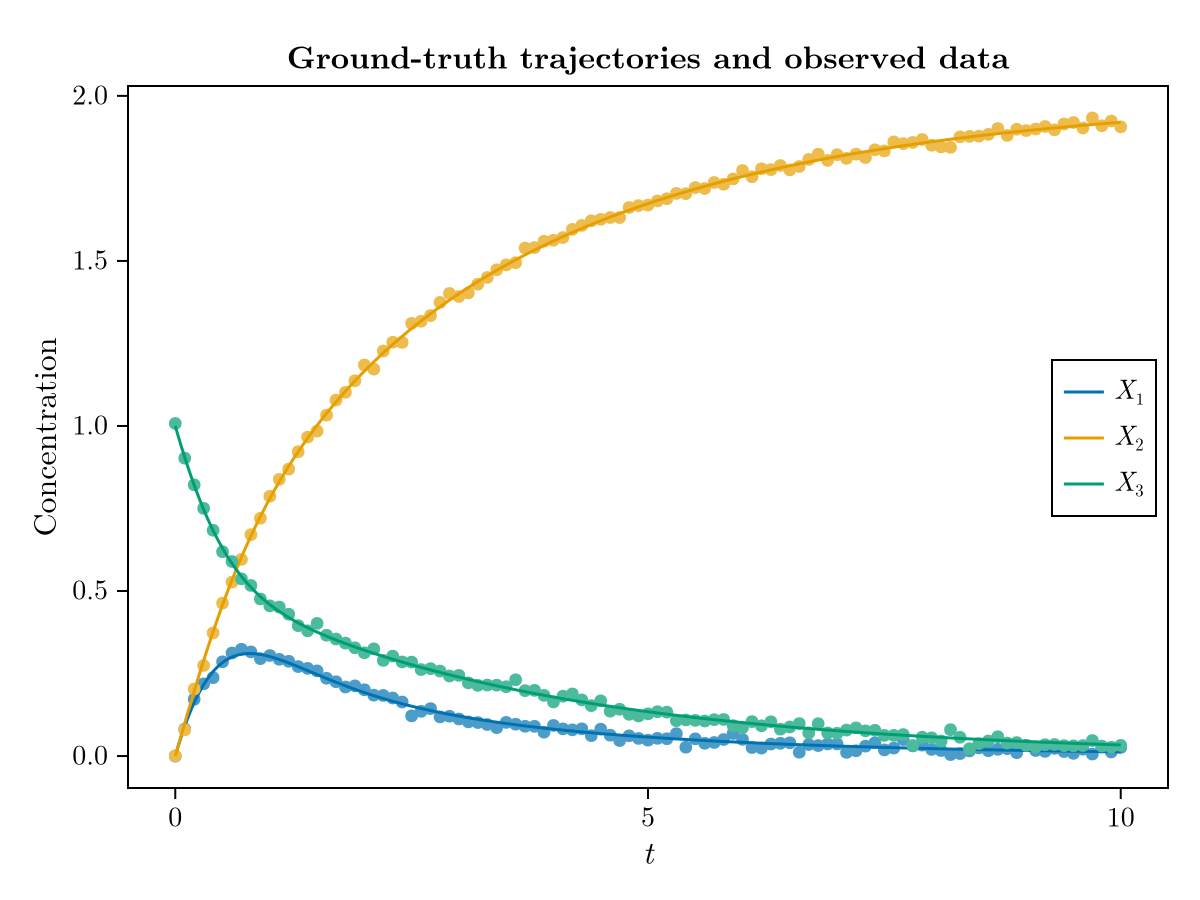

In [8]:
# to plot trajectories, we extract ODE solution for dense grid of timepoints
t_grid = range(t_span..., 1001);
true_sol_grid = true_sol(t_grid);

f = Figure()
ax = Axis(f[1,1], xlabel=L"$t$", ylabel="Concentration", title="Ground-truth trajectories and observed data")
n_species = size(data, 1)
for i in 1:n_species
    scatter!(t_obs, data[i,:], color=lighten(palette[i], 0.7))
    lines!(t_grid, [pt[i] for pt in true_sol_grid.u], label=L"$X_%$i$") # `L` parses the string as LaTeX, `%$i` substitutes the value of `i`
end
axislegend(position=:rc);
current_figure()

### Standard parameter inference

When investigating a system such as a CRN, simulating data from its ODEs is considered to be a *forward problem*; that is, to produce observations based on a parameterised model of the system. The *inverse problem* involves inferring or estimating the values of the model parameters using observations of the system. For CRNs, the standard inverse problem is to infer the rate constants from observed data, where the **reactions are assumed to be known**. One approach to this inverse problem is to find the rate constants that minimise a loss function that quantifies the discrepancy between the predictions based on those rate constants and the observed data. Here, we use the sum of squared errors in our loss function, while assuming that the initial state $(X_1(0), X_2(0), X_3(0)) = (0,0,1)$ is known.

In [9]:
function loss_func_known_rx(rate_consts)
	oprob = remake(true_oprob, p=(:k₁ => rate_consts[1], :k₁₈ => rate_consts[2], :k₁₃ => rate_consts[3])); 
	sol = try 
		solve(oprob, saveat=t_obs); # simulate the ODE
	catch e
		return Inf # return Inf if the ODE simulation diverges
	end
	sum(abs2.(data .- reduce(hcat, sol.u))) / (2*σ^2)
end

loss_func_known_rx (generic function with 1 method)

Note that the sum of squared errors is divided by $2\sigma^2$, which is taken from the log-density of a normal distribution. We assume that the value of $\sigma$ is known during inference. As a sanity check, the loss function evaluated for the ground-truth rate constants should be close to the total number of observations divided by $2$, i.e. $151.5$. Evaluating the loss function for rate constants far from the ground truth should give a much larger value.

In [10]:
loss_func_known_rx([1,1,1]) # small loss value for ground-truth rate constants

157.8927677549655

In [11]:
loss_func_known_rx([0,0,0]) # large loss value for rate constants far from ground truth

1.5789570508381003e6

To obtain estimates of the rate constants, we minimise the loss function using the [BFGS algorithm](https://julianlsolvers.github.io/Optim.jl/stable/algo/lbfgs/), which is based on the first derivatives of the loss function. These derivatives are obtained with [forward-mode automatic differentation](https://juliadiff.org/ForwardDiff.jl/stable/). We set lower and upper bounds for the rate constants at $k_\text{min}=10^{-10}$ and $k_\text{max}=10^{2}$ respectively, and start the optimisation process with random guesses (uniform between $0$ and $1$) for the rate constants.

In [12]:
using Optim
using LineSearches
opt_args = (
    Fminbox(BFGS(linesearch = LineSearches.BackTracking())), # optimisation algorithm
    Optim.Options(x_abstol=1e-10, f_abstol=1e-10, outer_x_abstol=1e-10, outer_f_abstol=1e-10) # optimisation options
);

As a technical aside, we pass functions to `Optim` with a wrapper to reduce compilation time later, for details see [this post](https://discourse.julialang.org/t/understanding-compilation-with-optim-jl-and-ordinarydiffeq-jl/124566).

In [13]:
struct FunctionWrapper
    f::Function
end
(wrapper::FunctionWrapper)(arg) = wrapper.f(arg);

In [14]:
n_true_rx = length(true_kmap)
# bounds for rate constants
LB = 1e-10; UB = 1e2;
lower_bounds = LB .* ones(n_true_rx)
upper_bounds = UB .* ones(n_true_rx)
# initial guess for rate constants (guess between 0 and 1)
Random.seed!(rng, 1) # for reproducibility
start_pt = rand(rng, n_true_rx)

# this is slow due to compilation
res = optimize(FunctionWrapper(loss_func_known_rx), lower_bounds, upper_bounds, start_pt, opt_args...; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.570347e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 1.0e-10
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 1.0e-10
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.00e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    6
    f(x) calls:    218
    ∇f(x) calls:   42


We check that the inferred rate constants, i.e. the rate constants which minimise the loss function, have values close to the ground truth $(k_{1},k_{13},k_{18})=(1,1,1)$.

In [15]:
res.minimizer

3-element Vector{Float64}:
 1.0028839519936006
 0.987573544228878
 0.9936620992920485

In practice, rate constants can vary over multiple scales across the reactions. It is therefore [recommended for optimisation to be performed at a log scale](https://doi.org/10.1093/bioinformatics/bty736), as we show below. After optimisation, we then take the exponential of the solution to transform it back to original scale of rate constants. Note that this optimisation run is much faster not because of less calls to the loss function, but because the previous run incurred a lot of compilations (`FunctionWrapper` avoids recompilation here).

In [16]:
loss_func_known_rx_exp(θ) = loss_func_known_rx(exp.(θ)) # exp undoes the log transformation
res = optimize(FunctionWrapper(loss_func_known_rx_exp), log.(lower_bounds), log.(upper_bounds), log.(start_pt), opt_args...; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.570347e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 2.80e-17 ≤ 1.0e-10
    |x - x'|/|x'|          = 1.96e-15 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 1.0e-10
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.29e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    141
    ∇f(x) calls:   31


In [17]:
exp.(res.minimizer)

3-element Vector{Float64}:
 1.0028785766643458
 0.9875732402636045
 0.9936633723841283

### Defining a library CRN for structural inference

But what if the set of **reactions in the CRN are unknown**? Here, we come to an inverse problem concerning the *structure* of a model. Instead of assuming knowledge of the precise set of reactions involved in the system, we specify a set of *candidate reactions*, a small subset of which we assume are able to satisfactorily explain the observed data. We call the CRN formed by all candidate reactions the *library CRN*. For this tutorial, the reactants and products of each reaction are one of the complexes $\{X_1,X_2,X_3,X_1+X_2,X_2+X_3,X_1+X_3\}$ must be distinct. This results in $6\times 5=30$ candidate reactions. Instead of using the `@reaction_network` macro, here we [build a `ReactionSystem` programmatically](https://docs.sciml.ai/Catalyst/stable/model_creation/programmatic_CRN_construction/), which requires us to manually define the independent variable (time), the species, and the vector of reactions along with the rate constants as parameters.

In [18]:
t = default_t(); # time variable
xs = @species X₁(t) X₂(t) X₃(t)

complexes_vec = [xs[idx_vec] for idx_vec in [[1], [2], [3], [1, 2], [2, 3], [1, 3]]]; # all possible complexes
# define all ordered pairs of distinct complexes for reactions
pairs = [
	(reactants, products) for reactants in complexes_vec for products in complexes_vec 
	if reactants !== products
];
n_rx = length(pairs); # number of reactions
@parameters k[1:n_rx] # reaction rate constants
rx_vec = [
	Reaction(kval, reactants, products) for ((reactants, products), kval) in zip(pairs, k)
];

@named lib_crn = ReactionSystem(rx_vec, t, xs, k) # library CRN
lib_crn = complete(lib_crn) # `lib_crn` is defined using the `ReactionSystem` constructor, and so has to be manually marked as complete

Model lib_crn:
Unknowns (3): see unknowns(lib_crn)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(lib_crn)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

### Parameter estimation for the library CRN

To infer the set of reactions present in the system, we seek to estimate the rate constants of all reactions of the library CRN, with prior knowledge that most of these rate constants are zero. To this end, we minimise a *penalised* loss function that is the sum of our original loss function and a penalty function that increases with the rate constants. Similar to [Hoffmann et al. (2019)](https://doi.org/10.1063/1.5066099), we use an $L_1$ penalty, i.e. each rate constant $k$ incurs a penalty of $\lambda k$ for some hyperparameter $\lambda$. Such a penalty encourages values of the solution to be small where possible. We arbritarily choose a value of $\lambda=1$.

In [19]:
# create ODEProblem corresponding to the library CRN
lib_oprob = ODEProblem(lib_crn, x0map, t_span, zeros(n_rx));

function loss_func_unknown_rx(rate_consts)
    # `k` is the variable name defined along with the library CRN
	oprob = remake(lib_oprob, p=[k => rate_consts]);
	sol = try 
		solve(oprob, saveat=t_obs); # simulate the ODE
	catch e
		return Inf # return Inf if the ODE simulation diverges
	end
	sum(abs2.(data .- reduce(hcat, sol.u))) / (2*σ^2)
end

λ = 1.0 # penalty hyperparameter
# we optimise on log space, so θ = log k
penalised_func(θ) = loss_func_unknown_rx(exp.(θ)) + λ*sum(exp.(θ));

In [20]:
# sanity check for `penalised_func`, should be 3λ higher than original version
true_kvec = zeros(n_rx);
true_kvec[1] = true_kvec[13] = true_kvec[18] = 1.0
penalised_func(log.(true_kvec))

160.8927677549655

Note that this optimisation run is slow as compilations involving the library CRN are needed, subsequent runs will be faster.

In [21]:
# bounds for log rate constants
lower_bounds = log.(LB .* ones(n_rx))
upper_bounds = log.(UB .* ones(n_rx))
# random guesses for log rate constants (uniform between 0 and 1)
Random.seed!(rng, 1) # for reproducibility
start_pt = log.(rand(rng, n_rx))

res = optimize(FunctionWrapper(penalised_func), lower_bounds, upper_bounds, start_pt, opt_args...; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.576576e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 6.94e-18 ≤ 1.0e-10
    |x - x'|/|x'|          = 1.46e-19 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 1.0e-10
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.30e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    4
    f(x) calls:    1115
    ∇f(x) calls:   845


To check if the optimisation result is sensible, we reconstruct ODE trajectories from the optimisation solution, and compare them to the ground truth trajectories.

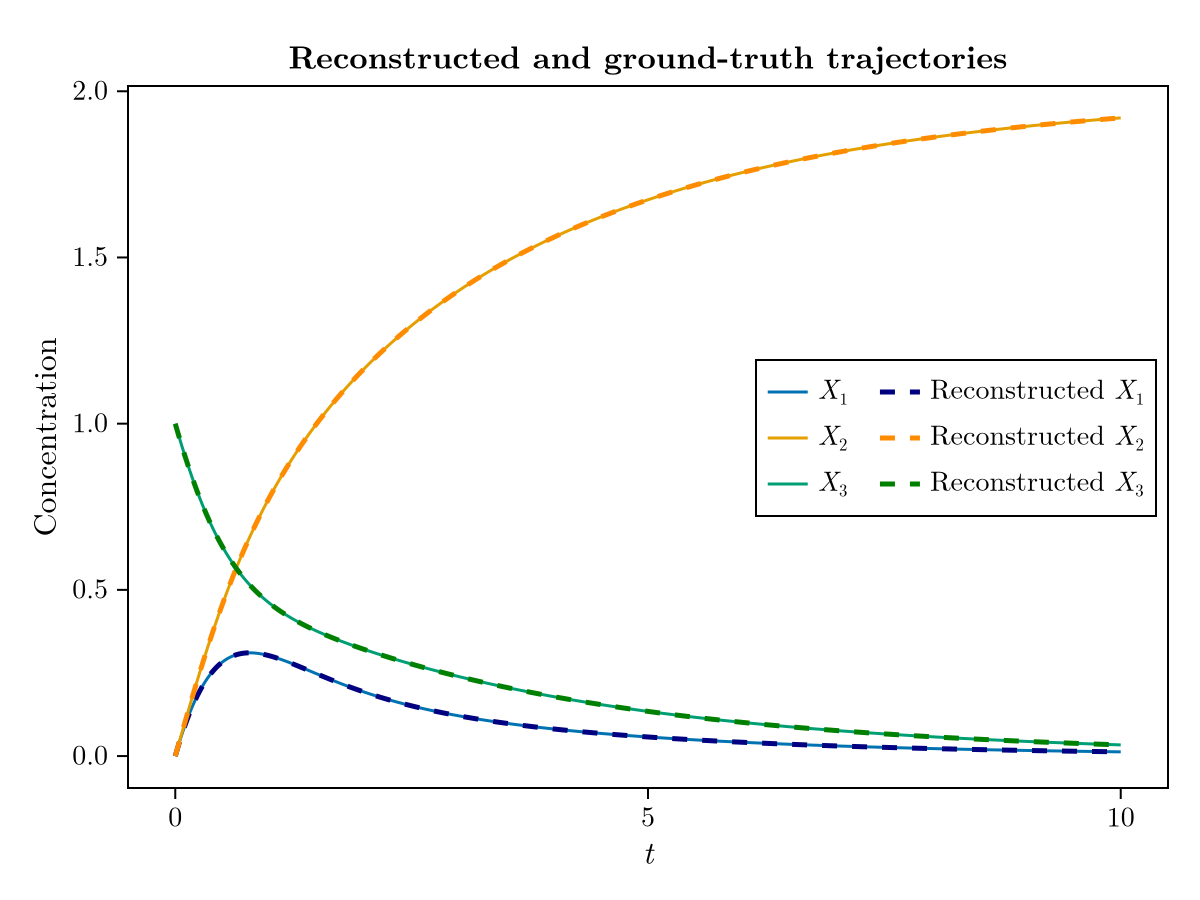

In [22]:
f = Figure()
ax = Axis(f[1,1], xlabel=L"$t$", ylabel="Concentration", title="Reconstructed and ground-truth trajectories")
est_kvec = exp.(res.minimizer)
recon_oprob = remake(lib_oprob, p=[k => est_kvec])
recon_sol_grid = solve(recon_oprob)(t_grid)
for i in 1:n_species
    lines!(t_grid, [pt[i] for pt in true_sol_grid.u], label=L"$X_%$i$", color=palette[i])
    lines!(
        t_grid, [pt[i] for pt in true_sol_grid.u], label=L"Reconstructed $X_%$i$", 
        color=[:navy, :darkorange, :green][i], linestyle=:dash, linewidth=2.5
    )
end
axislegend(position=:rc, nbanks=2);
current_figure()

The reconstructed trajectories resembles the ground truth well, so we move on to validating the rate constant estimates. Again, we compare the estimated rate constants with the ground truth. 

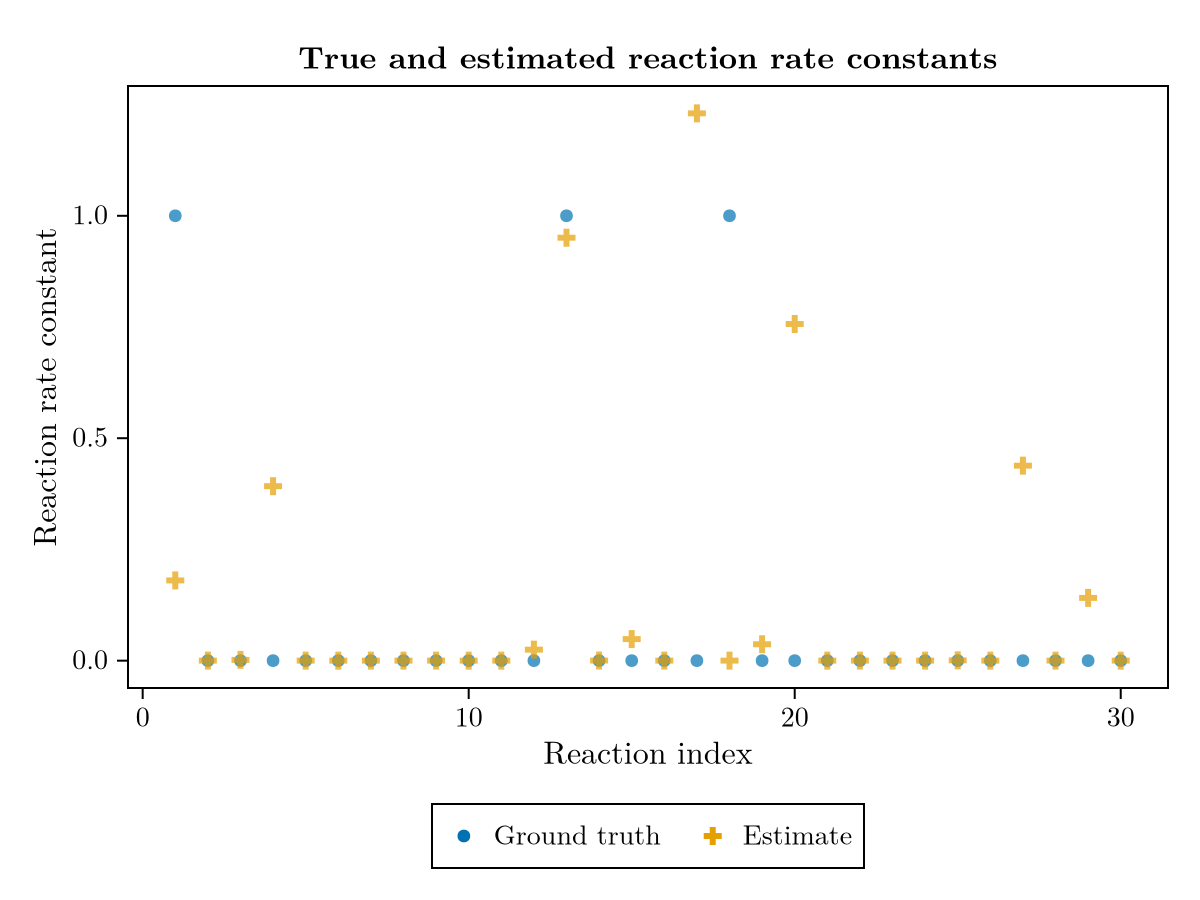

In [23]:
f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, est_kvec, alpha=0.7, label="Estimate", marker=:cross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

The only reaction whose rate constant we estimate well is reaction $13$. Our inferred CRN is different from the ground truth, yet the trajectories are reconstructed closely. This reflects a non-identifiability issue known as *dynamical equivalence*, where two different CRNs can produce the same ODE systems. Consider the following two CRNS.

In [24]:
@named crn_single = ReactionSystem(rx_vec[[18]], t, xs, k)
convert(ODESystem, complete(crn_single))

Model crn_single:
Equations (3):
  3 standard: see equations(crn_single)
Unknowns (3): see unknowns(crn_single)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(crn_single)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

In [25]:
@named crn_double = ReactionSystem(rx_vec[[17, 20]], t, xs, k)
convert(ODESystem, complete(crn_double))

Model crn_double:
Equations (3):
  3 standard: see equations(crn_double)
Unknowns (3): see unknowns(crn_double)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(crn_double)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

In the code above, we see that reactions $17$ and $20$ together contribute the same dynamics as reaction $18$ when $k_{17} = k_{18} = k_{20}$, i.e. the corresponding CRNs are dynamically equivalent. This is the principle that explains why we can reconstruct the ground-truth trajectories with a CRN different from the ground truth. However, this also reveals that the minimum found by our optimisation procedure is not a *global* minimum, since $k_{17}+k_{20}$ incurs unnecessary penalty. The standard remedy for optimisation problems that get stuck in suboptimal minima is to perform multiple optimisation runs each with different starting points, as we show below.

In [26]:
# run multiple starts of optimisation, return run with lowest optimised value
function multistart_optimize(func, start_pts, lower_bounds, upper_bounds, opt_args)
    wrapper = FunctionWrapper(func)
    res_vec = [
        optimize(wrapper, lower_bounds, upper_bounds, start_pt, opt_args...; autodiff = :forward)
        for start_pt in start_pts
    ]
    return argmin((res) -> res.minimum, res_vec)
end

Random.seed!(rng, 1) # seed random number generator again to include same starting point
n_starts = 10
start_pts = [log.(rand(rng, n_rx)) for _ in 1:n_starts]
multistart_res = multistart_optimize(penalised_func, start_pts, lower_bounds, upper_bounds, opt_args)
multistart_res.minimum # optimised value from multi-start optimisation

156.6405048166637

In [27]:
res.minimum # optimised value from single-start optimisation

157.6576464495518

Indeed, multi-start optimisation returned a lower optimised value than our previous single-start optimisation. Again, we visualise the rate constant estimates.

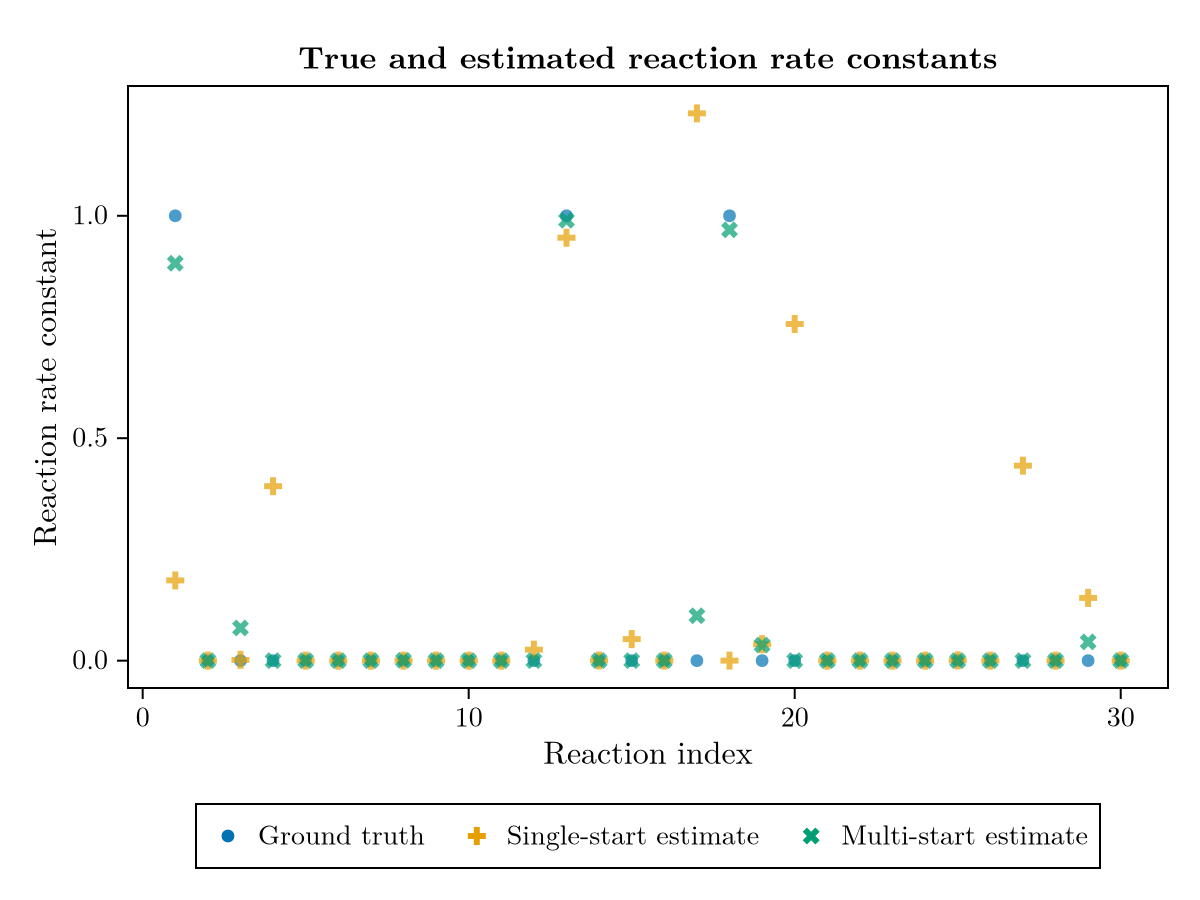

In [28]:
multistart_est_kvec = exp.(multistart_res.minimizer)

f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, est_kvec, alpha=0.7, label="Single-start estimate", marker=:cross, markersize=12)
scatter!(1:n_rx, multistart_est_kvec, alpha=0.7, label="Multi-start estimate", marker=:xcross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

Our multi-start estimation procedure strongly suggests that reactions $1$, $13$, $18$ are present in the CRN. However, it is less clear whether reactions $3$, $17$, $19$, $29$ are present in the CRN.

### Reaction network inference

Given that visual inspection is insufficient to infer which reactions are present in the CRN, we aim to perform this inference quantitatively instead. There are multiple approaches to this requiring varying levels of computational effort (used in variable selection in regression problems), here we develop a method that is rather *ad hoc* but quick to compute.

To get a parsimonious CRN, we sequentially include entries of the rate constant vector, starting from the largest values, until the model fit is similar to the model fit with all estimated constants included. For this part, we quantify model fit via the loss function without any penalty function. We will say that the optimised loss values differ by less than 1, then the model fits are considered similar enough.

In [29]:
function check_parsimony(est_kvec)
    full_loss = loss_func_unknown_rx(est_kvec)
    tmp_kvec = zeros(n_rx)
    for (num, idx) in  enumerate(reverse(sortperm(est_kvec)))
        tmp_kvec[idx] = est_kvec[idx]
        loss_offset = loss_func_unknown_rx(tmp_kvec) - full_loss
        println("Number of reactions = $num, Loss offset = $loss_offset")
    end
end

check_parsimony(multistart_est_kvec)

Number of reactions = 1, Loss offset = 587544.0435735721
Number of reactions = 2, Loss offset = 652604.6317380023
Number of reactions = 3, Loss offset = 593.5874720099091
Number of reactions = 4, Loss offset = 2161.643447020081
Number of reactions = 5, Loss offset = 129.0937284885812
Number of reactions = 6, Loss offset = 250.87747641222015
Number of reactions = 7, Loss offset = 3.4111664161834483
Number of reactions = 8, Loss offset = 0.01361364154365674
Number of reactions = 9, Loss offset = 0.00020900498722653538
Number of reactions = 10, Loss offset = 0.00013401433022863785
Number of reactions = 11, Loss offset = 1.1979372317227899e-5
Number of reactions = 12, Loss offset = -6.73386438165835e-7
Number of reactions = 13, Loss offset = -6.492547868219845e-7
Number of reactions = 14, Loss offset = 2.2919735442883393e-7
Number of reactions = 15, Loss offset = -2.9897000786149874e-7
Number of reactions = 16, Loss offset = -2.1220921553322114e-7
Number of reactions = 17, Loss offset = -4

The difference in loss function is insignificant once the $8$ reactions with the largest rate constant estimates are included. The reactions that we infer to be present in the CRN are shown below. The first $3$ reactions are in the ground-truth CRN, while the other $5$ reactions are extraneous (false positives). These extraneous reactions are indicative of a overfitted solution.

In [30]:
println(reverse(sortperm(multistart_est_kvec))[1:8])

[13, 18, 1, 17, 3, 29, 19, 8]


### Hyperparameter tuning

At this point, one could potentially obtain a more parsimonious CRN by repeating the estimation/inference procedure with these $8$ reactions (instead of the original $30$ reactions), though we do not go for this approach. One could instead try to adjust the penalty hyperparameter $\lambda$ to find a more parsimonious CRN. Here, we repeat the estimation for a $10$ values of $\lambda$, namely $\lambda = 2^{-3}, 2^{-2}, \ldots, 2^6$. To obtain a parsimonious CRN, we select the run with the largest value of $\lambda$ that still gives a reasonable model fit, which we again quantify via the un-penalised loss function. The following code takes a few minutes to run, as we are performing $10$ instances of multi-start optimisation.

In [31]:
λvec = 2.0 .^ (-3:6)
resvec = [];
for λval in λvec
    penalised_func(θ) = loss_func_unknown_rx(exp.(θ)) + λval*sum(exp.(θ))
    @time res = multistart_optimize(penalised_func, start_pts, lower_bounds, upper_bounds, opt_args)
    push!(resvec, res)
end

 27.124685 seconds (184.32 M allocations: 11.370 GiB, 6.34% gc time, 0.25% compilation time)
 30.349304 seconds (182.77 M allocations: 11.180 GiB, 5.93% gc time, 0.29% compilation time)


 35.247650 seconds (245.19 M allocations: 15.031 GiB, 6.14% gc time, 0.26% compilation time)
 26.455979 seconds (190.15 M allocations: 11.763 GiB, 6.32% gc time, 0.30% compilation time)


 22.238476 seconds (164.51 M allocations: 10.089 GiB, 6.29% gc time, 0.30% compilation time)
 26.713345 seconds (176.09 M allocations: 10.839 GiB, 5.93% gc time, 0.26% compilation time)


 30.907275 seconds (223.11 M allocations: 13.636 GiB, 6.18% gc time, 0.21% compilation time)
 29.736517 seconds (216.53 M allocations: 13.298 GiB, 6.25% gc time, 0.23% compilation time)


 29.985101 seconds (218.79 M allocations: 13.404 GiB, 6.23% gc time, 0.22% compilation time)
 30.803256 seconds (224.53 M allocations: 13.779 GiB, 6.18% gc time, 0.22% compilation time)


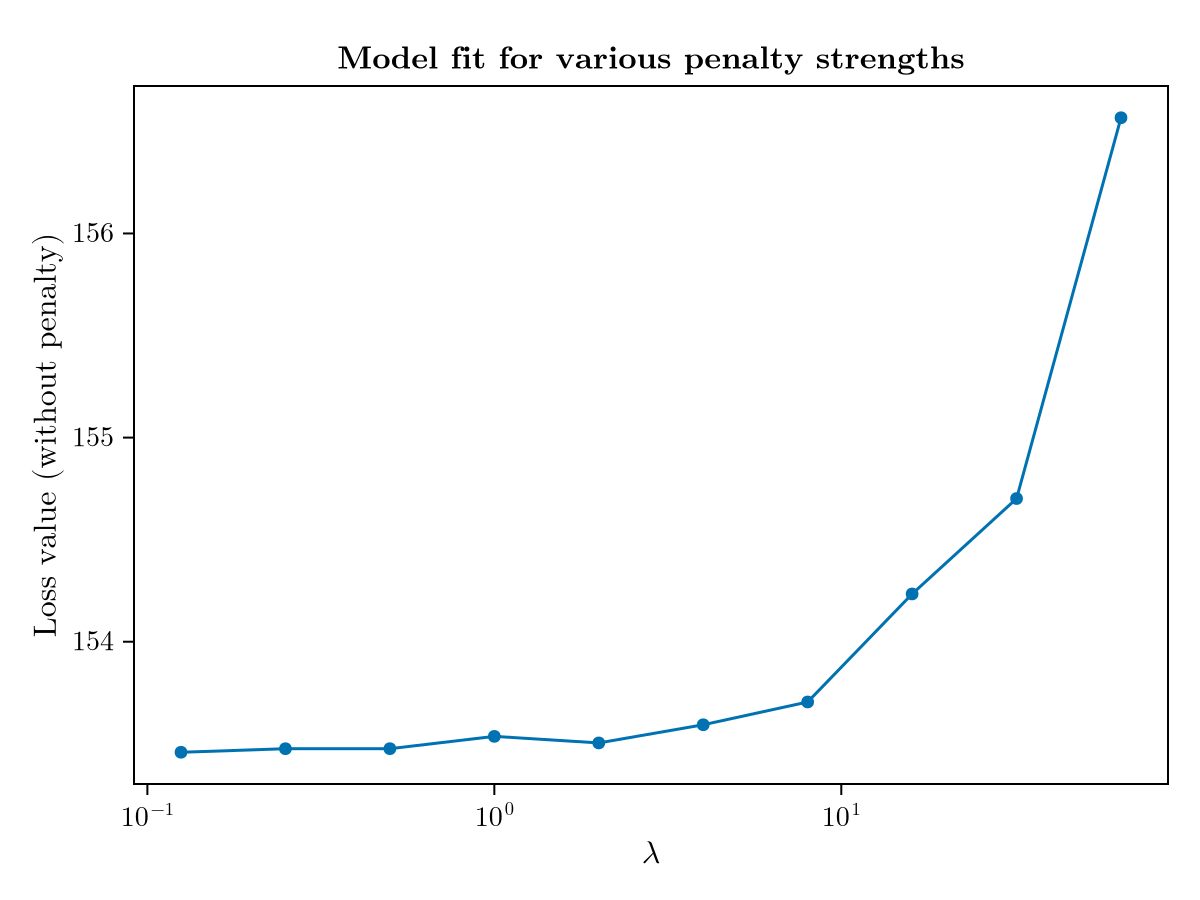

In [32]:
loss_vals = [loss_func_unknown_rx(exp.(res.minimizer)) for res in resvec]

f = Figure()
ax = Axis(f[1,1], xscale=log10, xlabel=L"$λ$", ylabel="Loss value (without penalty)", title="Model fit for various penalty strengths")
scatterlines!(λvec, loss_vals)
current_figure()

In theory, the model fit should deteriorate as penalty strength increases, as increasing the penalty results in underfitting the data. This is largely true, but there can be exceptions since the multi-start optimisation is not guaranteed to find the global minimum. Out of the tested values of $\lambda$, we will proceed with the results obtained with $\lambda=0.125$ and $\lambda=8$, which are endpoints of the plateau in the plot above.

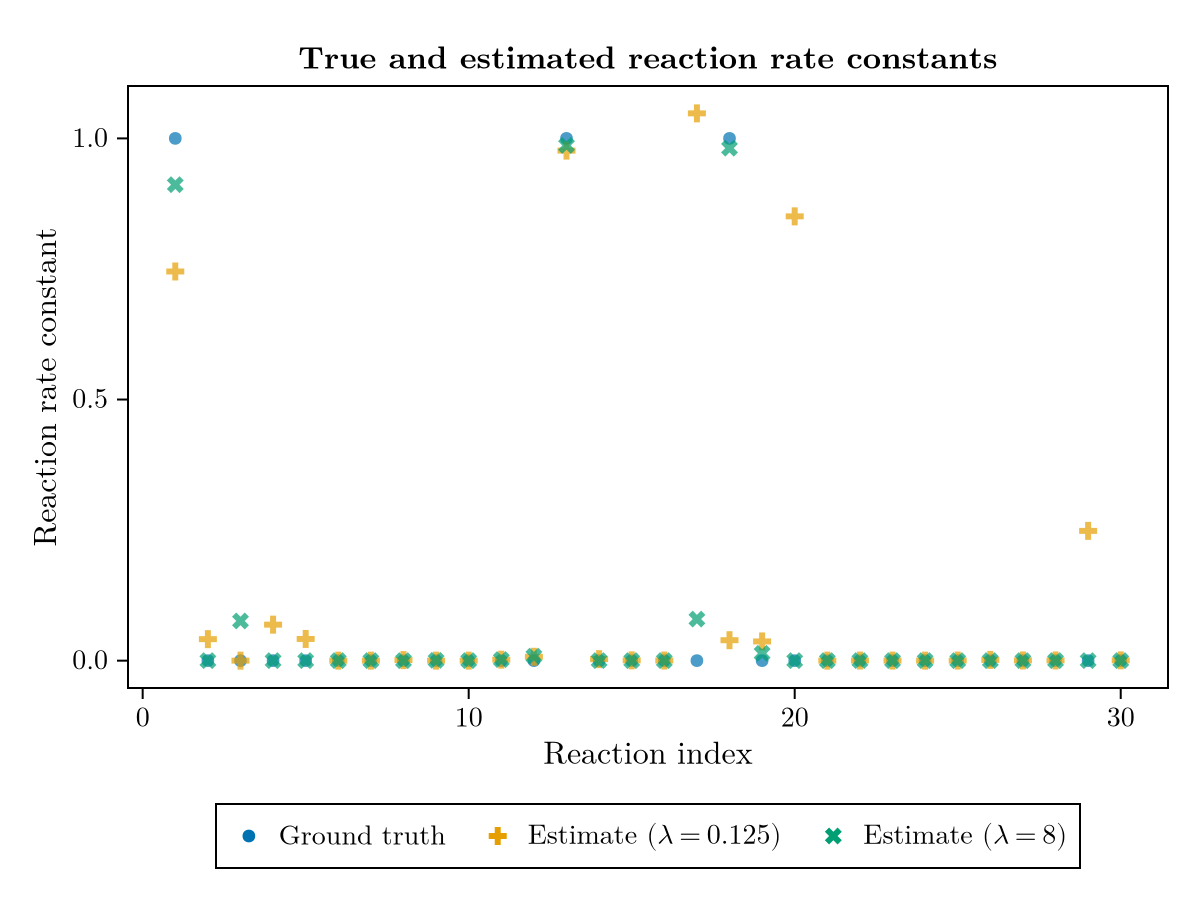

In [33]:
lowλ_est_kvec = exp.(resvec[1].minimizer)
highλ_est_kvec = exp.(resvec[7].minimizer)

f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, lowλ_est_kvec, alpha=0.7, label=L"Estimate $(λ=0.125)$", marker=:cross, markersize=12)
scatter!(1:n_rx, highλ_est_kvec, alpha=0.7, label=L"Estimate $(λ=8)$", marker=:xcross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

In [34]:
check_parsimony(highλ_est_kvec)

Number of reactions = 1, Loss offset = 587409.8746807209
Number of reactions = 2, Loss offset = 654384.9080391502
Number of reactions = 3, Loss offset = 500.42883326075935
Number of reactions = 4, Loss offset = 1546.9829556772156
Number of reactions = 5, Loss offset = 10.568974554269914
Number of reactions = 6, Loss offset = 14.872549137228816
Number of reactions = 7, Loss offset = 3.565508315761349
Number of reactions = 8, Loss offset = 10.692471722321756
Number of reactions = 9, Loss offset = 0.012262116420430402
Number of reactions = 10, Loss offset = 2.7542580482986523e-6
Number of reactions = 11, Loss offset = 0.0021999004408996825
Number of reactions = 12, Loss offset = 0.003810897738503627
Number of reactions = 13, Loss offset = 0.0003977701061899097
Number of reactions = 14, Loss offset = -0.0006983623246981097
Number of reactions = 15, Loss offset = -0.0008761843946558656
Number of reactions = 16, Loss offset = -0.00028162271684095685
Number of reactions = 17, Loss offset = -0

Note that even though $\lambda=0.125$ and $\lambda=8$ give similar loss values (without penalty), we can see that $\lambda=0.125$ gives more false positives. However, $\lambda=8$ has not given us a more parsimonious CRN than the CRN initially inferred with $\lambda=1$ (still need $9$ reactions for a good model fit), so the problem of overfitting remains.

### Alternative penalty function

The $L_1$ penalty function we have used thus far is a rather standard choice in regression, often under the name *lasso regression*. It is known to induce sparsity in coefficient estimates for linear regression, however we have not obtained sufficient sparsity for our application of CRN inference.

In this section, we explore an alternative penalty function used by [Gupta et al. (2020)](https://doi.org/10.1371/journal.pcbi.1007669). Recall that during optimisation, we constrained each rate constant $k$ between $k_\text{min} = 10^{-10}$ and $k_\text{max}=10^{2}$. We now set the penalty function to be $\lambda \log(k/k_\text{min})$ for some hyperparameter $\lambda$. In other words, the penalty increases linearly with $\log k$ instead, and is $0$ for $k=k_\text{min}$. We refer to this penalty function as the $\log L_1$ penalty. We use the same hyperparameter tuning procedure as we did with the $L_1$ penalty function.

In [35]:
alt_resvec = [];
for λval in λvec
    penalised_func(θ) = loss_func_unknown_rx(exp.(θ)) + λval*(sum(θ) .- n_rx*LB) # note θ = log k
    @time res = multistart_optimize(penalised_func, start_pts, lower_bounds, upper_bounds, opt_args)
    push!(alt_resvec, res)
end

 35.711801 seconds (255.13 M allocations: 15.837 GiB, 6.21% gc time, 0.22% compilation time)
 45.447968 seconds (317.60 M allocations: 19.718 GiB, 5.98% gc time, 0.12% compilation time)


 50.461579 seconds (355.83 M allocations: 22.057 GiB, 6.13% gc time, 0.13% compilation time)
 44.243690 seconds (310.02 M allocations: 19.253 GiB, 5.98% gc time, 0.16% compilation time)


 41.830412 seconds (296.21 M allocations: 18.547 GiB, 6.00% gc time, 0.12% compilation time)
 42.758114 seconds (300.17 M allocations: 18.692 GiB, 6.03% gc time, 0.12% compilation time)


 37.909468 seconds (267.49 M allocations: 16.721 GiB, 5.97% gc time, 0.13% compilation time)
 32.929595 seconds (227.79 M allocations: 14.292 GiB, 5.79% gc time, 0.15% compilation time)


 32.676710 seconds (203.93 M allocations: 12.882 GiB, 5.54% gc time, 0.15% compilation time)
 25.890843 seconds (173.33 M allocations: 10.816 GiB, 5.66% gc time, 0.19% compilation time)


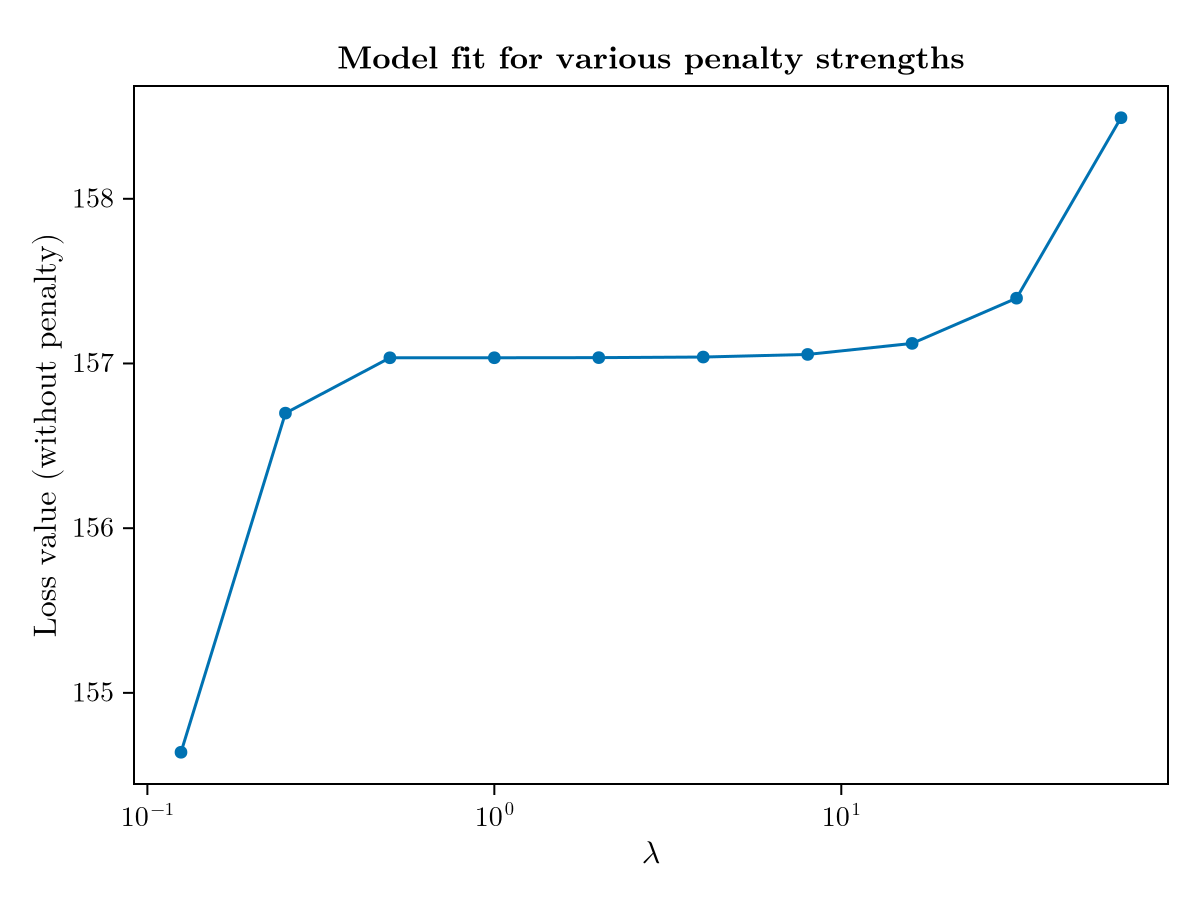

In [36]:
alt_loss_vals = [loss_func_unknown_rx(exp.(res.minimizer)) for res in alt_resvec]

f = Figure()
ax = Axis(
    f[1,1], xscale=log10, xlabel=L"$λ$", ylabel="Loss value (without penalty)", 
    title="Model fit for various penalty strengths"
)
scatterlines!(λvec, alt_loss_vals)
current_figure()

As we expect, model fit deteriorates as penalty strength increases. Yet this time there is a clear plateau from $\lambda=0.5$ to $\lambda=16$ of similar model fits. We will proceed our analysis with the results obtained with $\lambda=16$. The associated loss value $(\approx 157)$ is higher than the loss value from the previous section $(\approx 154)$, signalling a relatively worse fit. However, let us look at the rate constant estimates.

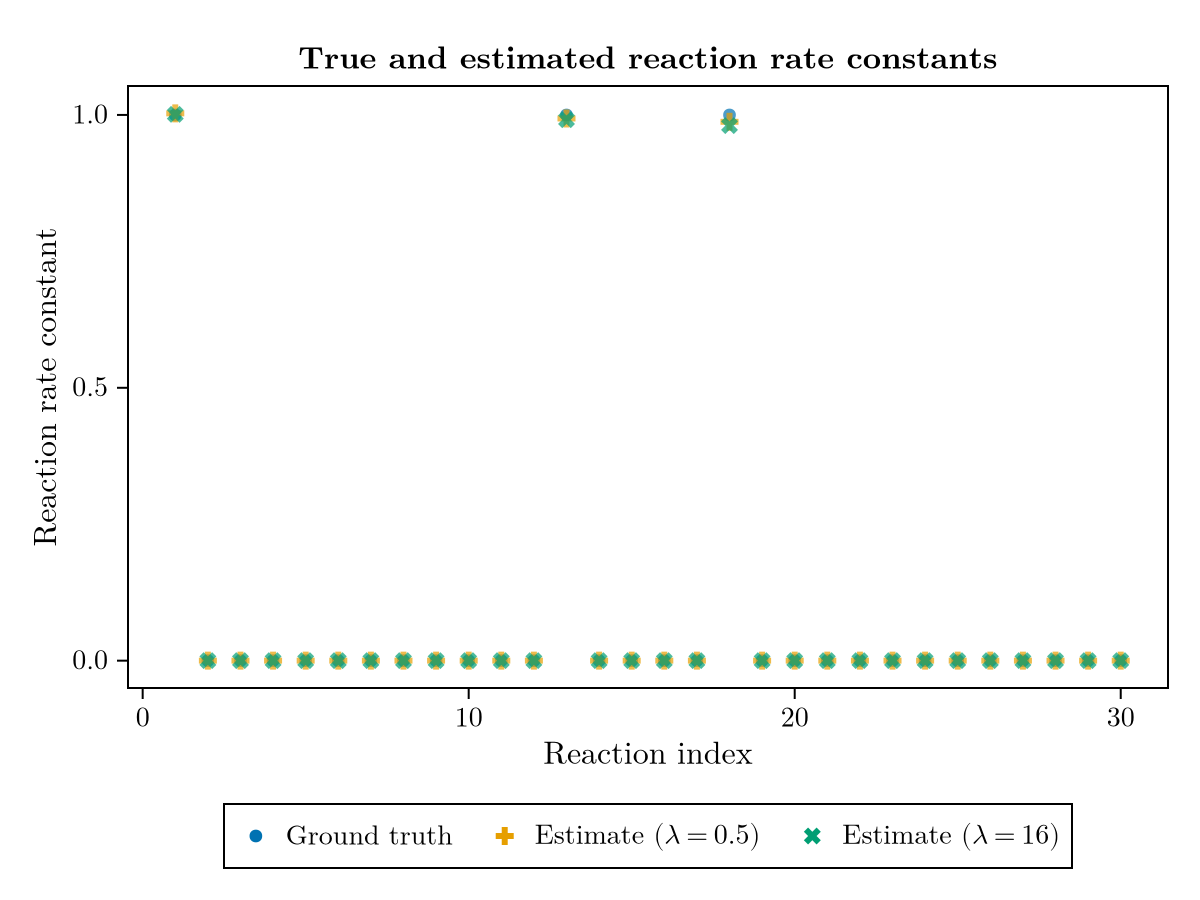

In [37]:
alt_lowλ_est_kvec = exp.(alt_resvec[3].minimizer)
alt_highλ_est_kvec = exp.(alt_resvec[8].minimizer)

f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, alt_lowλ_est_kvec, alpha=0.7, label=L"Estimate $(λ=0.5)$", marker=:cross, markersize=12)
scatter!(1:n_rx, alt_highλ_est_kvec, alpha=0.7, label=L"Estimate $(λ=16)$", marker=:xcross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

For both $\lambda=0.5$ and $\lambda=16$, the rate constants of the reactions in ground truth CRN are estimated well, and we do not see any false positives visually. We check this using the same network inference procedure.

In [38]:
check_parsimony(alt_highλ_est_kvec)

Number of reactions = 1, Loss offset = 1.578799928814516e6
Number of reactions = 2, Loss offset = 33234.89271689156
Number of reactions = 3, Loss offset = -2.902767022305852e-6
Number of reactions = 4, Loss offset = -2.8852897173692327e-6
Number of reactions = 5, Loss offset = -2.9067347497857554e-6
Number of reactions = 6, Loss offset = -2.8740593336351594e-6
Number of reactions = 7, Loss offset = -2.7809445839466207e-6
Number of reactions = 8, Loss offset = -2.2839092537196848e-6
Number of reactions = 9, Loss offset = -2.3220392790790356e-6
Number of reactions = 10, Loss offset = -2.5136753549759305e-6
Number of reactions = 11, Loss offset = -2.400254942358515e-6
Number of reactions = 12, Loss offset = -2.3828745554510533e-6
Number of reactions = 13, Loss offset = -2.427271027727329e-6


Number of reactions = 14, Loss offset = -2.3357316933925176e-6
Number of reactions = 15, Loss offset = -2.3943741780385608e-6
Number of reactions = 16, Loss offset = -2.570826865166964e-6
Number of reactions = 17, Loss offset = -2.0136853322583192e-6
Number of reactions = 18, Loss offset = -2.070478871019077e-6
Number of reactions = 19, Loss offset = -2.0463795351588487e-6
Number of reactions = 20, Loss offset = -2.1295976182500453e-6
Number of reactions = 21, Loss offset = -1.2044152128964924e-6
Number of reactions = 22, Loss offset = -3.8834002680232516e-8
Number of reactions = 23, Loss offset = -2.213604943790415e-8
Number of reactions = 24, Loss offset = 1.7342927094432525e-8
Number of reactions = 25, Loss offset = 3.5604983850134886e-8
Number of reactions = 26, Loss offset = -7.965653026076325e-8
Number of reactions = 27, Loss offset = -1.5823937360437412e-7
Number of reactions = 28, Loss offset = -6.754729042768304e-8
Number of reactions = 29, Loss offset = 6.371044491970679e-8
N

Clearly, only 3 reactions, i.e. reactions $1$, $3$, $18$, are needed for a parsimonious CRN.

In [39]:
reverse(sortperm(alt_highλ_est_kvec))[1:3]

3-element Vector{Int64}:
  1
 13
 18

Note that the issue of dynamical equivalence returns if a smaller value of $\lambda$ is used.

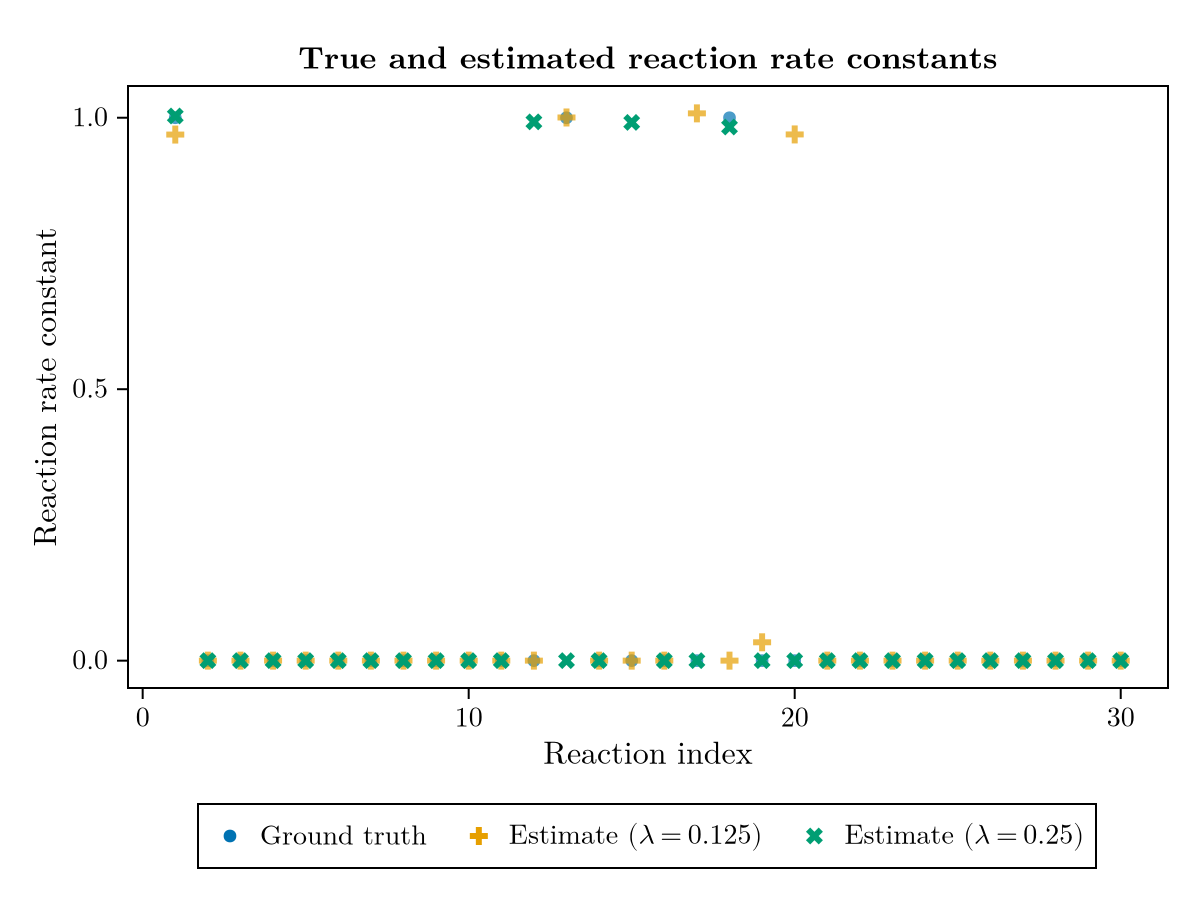

In [40]:
f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, exp.(alt_resvec[1].minimizer), alpha=0.7, label=L"Estimate $(λ=0.125)$", marker=:cross, markersize=12)
scatter!(1:n_rx, exp.(alt_resvec[2].minimizer), label=L"Estimate $(λ=0.25)$", marker=:xcross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

Why did changing the penalty function avoid overfitting? One possible answer comes from interpreting a penalty function as the negative log density of a prior distribution on the rate constants. Since most reactions in the library CRN are not present in the ground-truth CRN, their rate constants (regardless of whether the reactions are truly present) follow an extreme-value distribution. The $L_1$ penalty corresponds to an exponential prior, while the $\log L_1$ penalty corresponds to a prior with a power-law density. The tail of a power-law distribution is heavier than an exponential tail, making it more suitable for describing an extreme-value distribution.